# Лабораторная 2

# Тема: Функции активации и однослойный перцептрон


## Блок 1: Импорт библиотек


In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

## Блок 2: Реализация функций активации и их производных


Каждая функция имеет уникальные математические свойства:

- Тождественная - линейная функция, $f(x)=x$.
- Ступенчатая - пороговая функция, возвращает 0 или 1.
- Сигмоида - гладкая S-образная кривая, диапазон $[0,1]$.
- Гиперболический тангенс - S-образная кривая, диапазон $[-1,1]$.
- Арктангенс - гладкая функция, асимптоты при $\pm\frac{\pi}{2}$.
- Softsign - похожа на $arctan$, но с более простой формулой.

Так же для каждой функции реализуем производную, которая критически важна для обучения методом градиентного спуска.


In [180]:
class ActivationFunctions:
    """Класс для реализации функций активации и их производных"""
    
    @staticmethod
    def identity(x):
        """Тождественная функция: f(x) = x"""
        return x
    
    @staticmethod
    def identity_derivative(x):
        """Производная тождественной функции: f'(x) = 1"""
        return np.ones_like(x) # Массив едениц  
    
    @staticmethod
    def step(x):
        """Ступенчатая функция (единичная ступенька)"""
        return np.where(x >= 0, 1, 0)
    
    @staticmethod
    def step_derivative(x):
        """Производная ступенчатой функции (используем субаппроксимацию)"""
        # Для обучения используем производную от сигмоиды как аппроксимацию
        return np.zeros_like(x)
    
    @staticmethod
    def sigmoid(x):
        """Сигмоида (логистическая функция)"""
        # Для стабильности вычислений (Против переполнения)
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative(x):
        """Производная сигмоиды: f'(x) = f(x) * (1 - f(x))"""
        s = ActivationFunctions.sigmoid(x)
        return s * (1 - s)
    
    @staticmethod
    def tanh(x):
        """Гиперболический тангенс"""
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x):
        """Производная гиперболического тангенса: f'(x) = 1 - f(x)^2"""
        return 1 - np.tanh(x)**2
    
    @staticmethod
    def arctan(x):
        """Арктангенс"""
        return np.arctan(x)
    
    @staticmethod
    def arctan_derivative(x):
        """Производная арктангенса: f'(x) = 1 / (1 + x^2)"""
        return 1 / (1 + x**2)
    
    @staticmethod
    def softsign(x):
        """Softsign функция: f(x) = x / (1 + |x|)"""
        return x / (1 + np.abs(x))
    
    @staticmethod
    def softsign_derivative(x):
        """Производная softsign: f'(x) = 1 / (1 + |x|)^2"""
        return 1 / (1 + np.abs(x))**2

af = ActivationFunctions()

## Блок 3: Визуализация функций активации

Для лучшего представления визуализируем функции.


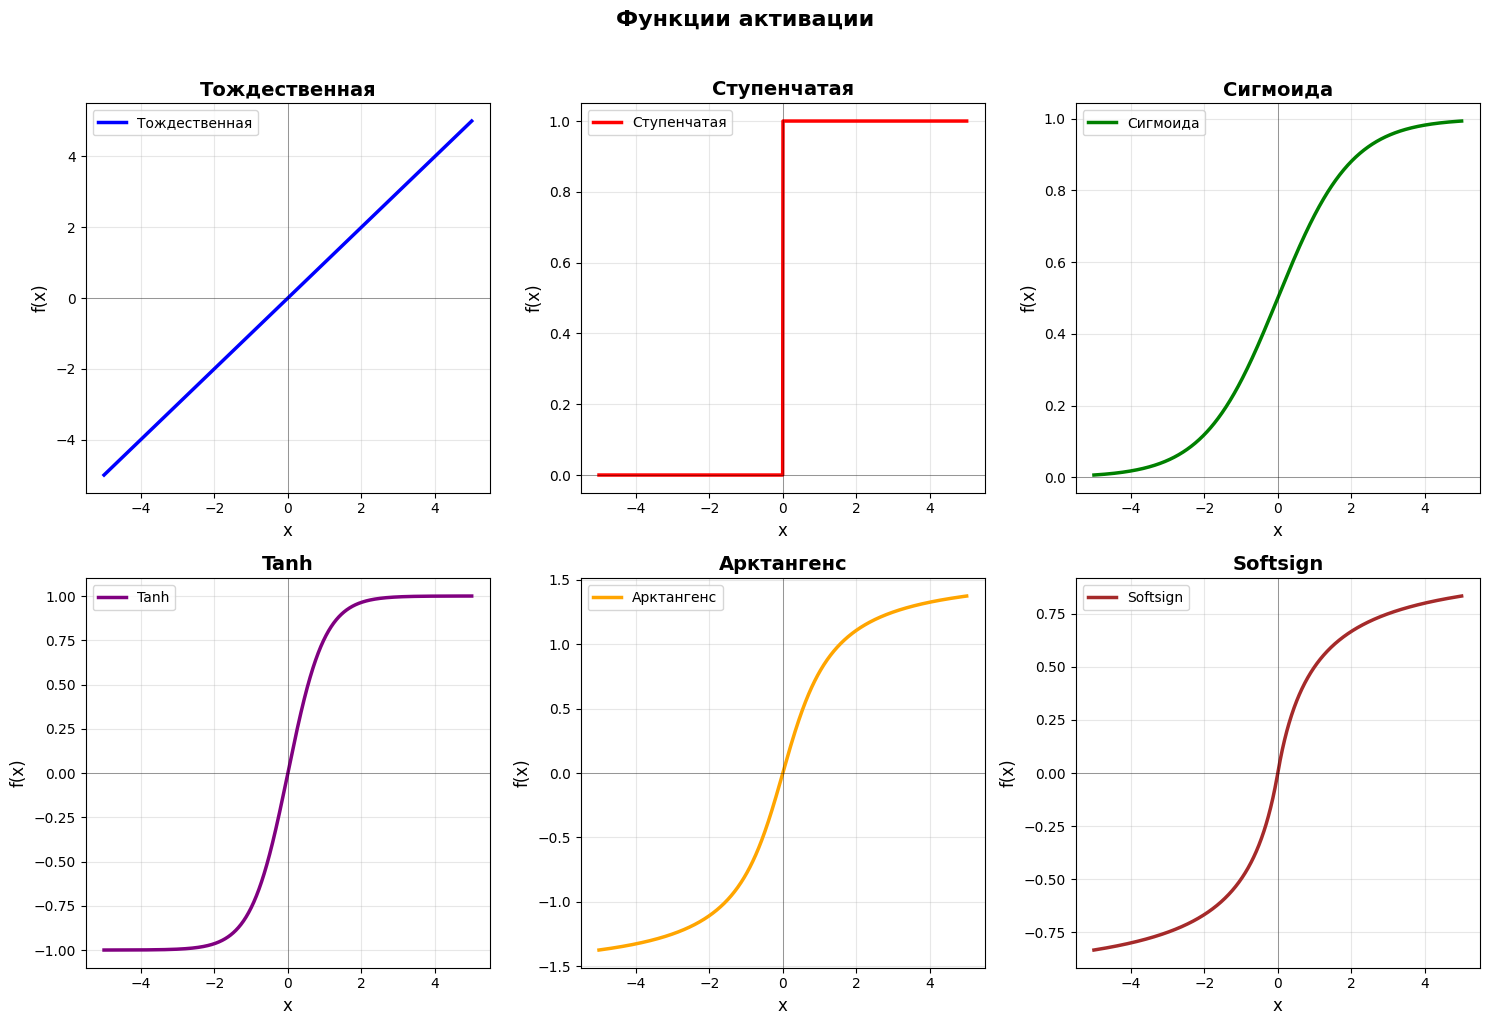

In [181]:
def plot_activation_functions():
    """Визуализация всех функций активации"""
    
    x = np.linspace(-5, 5, 1000)
    
    # Создаем сетку графиков
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Список функций для визуализации
    functions = [
        ("Тождественная", af.identity, 'blue'),
        ("Ступенчатая", af.step, 'red'),
        ("Сигмоида", af.sigmoid, 'green'),
        ("Tanh", af.tanh, 'purple'),
        ("Арктангенс", af.arctan, 'orange'),
        ("Softsign", af.softsign, 'brown')
    ]
    
    for i, (name, func, color) in enumerate(functions):
        ax = axes[i]
        y = func(x)
        ax.plot(x, y, color=color, linewidth=2.5, label=name)
        ax.set_title(name, fontsize=14, fontweight='bold')
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel('f(x)', fontsize=12)
        ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
        ax.axvline(x=0, color='black', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle('Функции активации', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Запускаем визуализацию
plot_activation_functions()

## Блок 4: Визуализация производных функций активации

Раз уж занялись визуализацей не будем забывать про производные функций.

Графики помогут нам увидеть, как быстро изменяется каждая функция и какие проблемы есть у каждой из функций.

- У step производная везде 0 (кроме $x=0$, где она не определена), что является проблемой для градиентного спуска.
- У sigmoid и tanh производные малы на "хвостах", а это проблема исчезающих градиентов (при больших по модулю $x$ значение производной стремится нулю (очень маленькое)).
- У arctan и softsign производные убывают медленнее, что потенциально лучше для глубоких сетей.


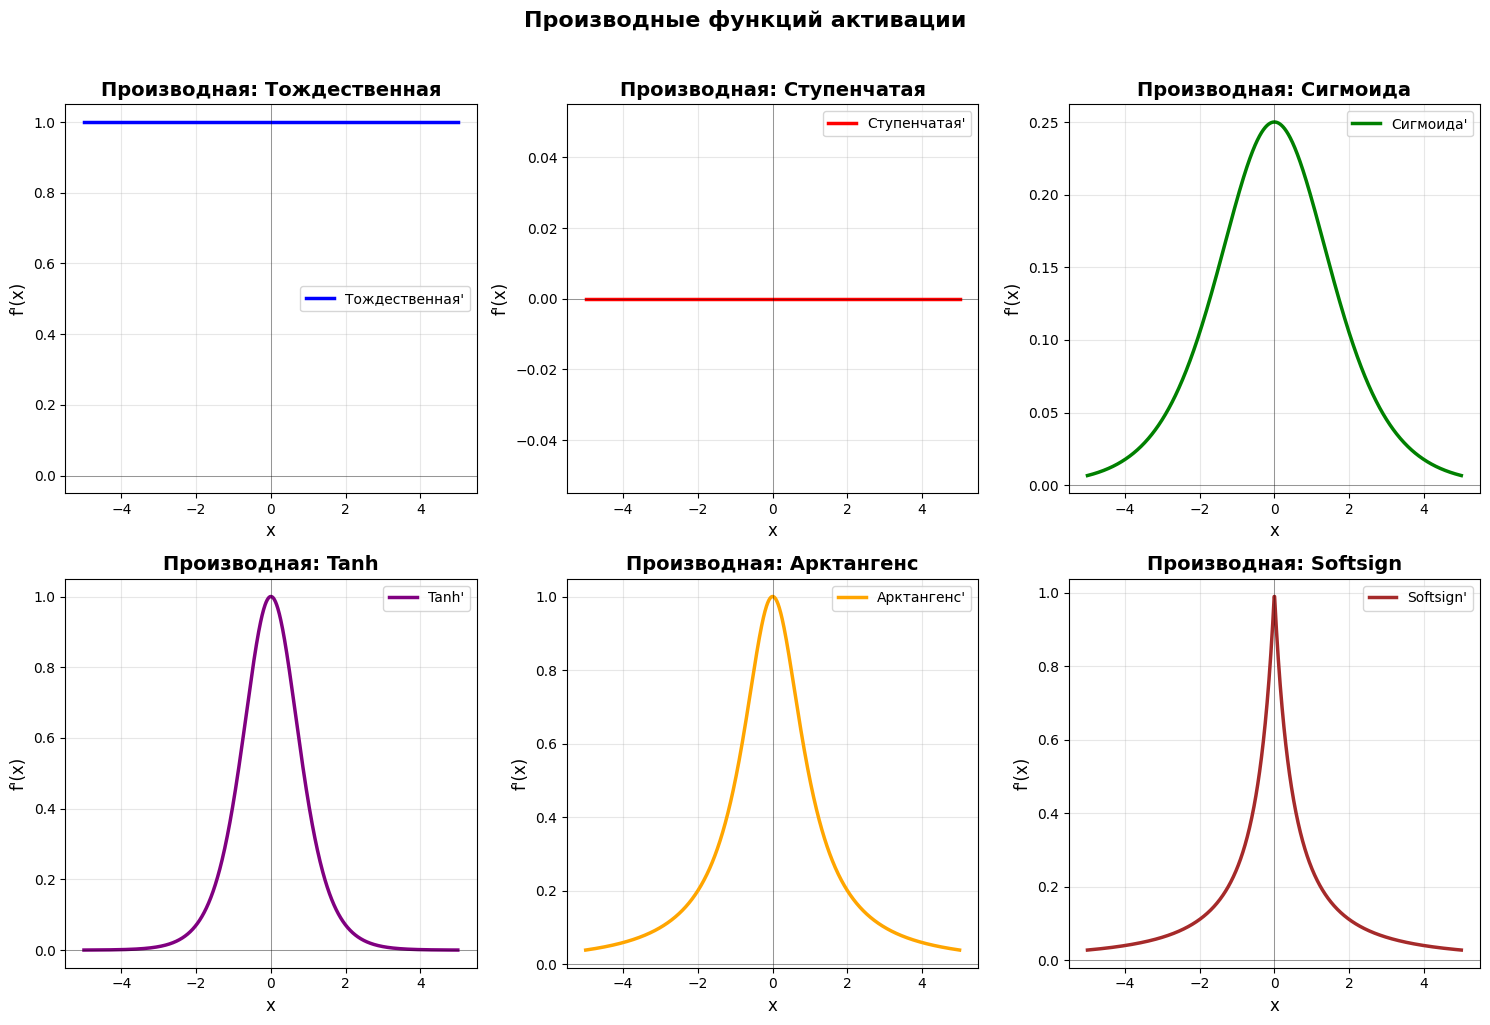

In [182]:
def plot_activation_derivatives():
    """Визуализация производных всех функций активации"""
    
    x = np.linspace(-5, 5, 1000)
    
    # Создаем сетку графиков
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Список функций и их производных
    derivatives = [
        ("Тождественная", af.identity_derivative, 'blue'),
        ("Ступенчатая", af.step_derivative, 'red'),
        ("Сигмоида", af.sigmoid_derivative, 'green'),
        ("Tanh", af.tanh_derivative, 'purple'),
        ("Арктангенс", af.arctan_derivative, 'orange'),
        ("Softsign", af.softsign_derivative, 'brown')
    ]
    
    for i, (name, deriv_func, color) in enumerate(derivatives):
        ax = axes[i]
        y = deriv_func(x)
        ax.plot(x, y, color=color, linewidth=2.5, label=f"{name}'")
        ax.set_title(f"Производная: {name}", fontsize=14, fontweight='bold')
        ax.set_xlabel('x', fontsize=12)
        ax.set_ylabel("f'(x)", fontsize=12)
        ax.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
        ax.axvline(x=0, color='black', linewidth=0.5, alpha=0.5)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle('Производные функций активации', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Запускаем визуализацию
plot_activation_derivatives()

## Блок 5: Реализация однослойного перцептрона


Напишем класс SingleLayerPerceptron с методами:

- **init**() — инициализация весов и выбора функции активации.
- forward() — прямой проход (вычисление выхода).
- predict() — получение бинарных предсказаний.
- train() — обучение методом градиентного спуска.
- Вспомогательные методы

##### Как это работает?

- Входной слой: принимает признаки.
- Взвешенная сумма: $z = w·x + b$.
- Функция активации: $a = f(z)$.
- Выход: предсказание.


In [183]:
class SingleLayerPerceptron:
    
    def __init__(self, input_size, activation_name='sigmoid'):
        self.input_size = input_size
        
        # Инициализация весов и смещения
        self.weights = np.random.randn(input_size) * 0.1
        self.bias = np.random.randn() * 0.1
        
        # Выбор функции активации
        self.activation_name = activation_name
        self.set_activation_function(activation_name)
        
        # История обучения
        self.loss_history = []
        self.accuracy_history = []
    
    def set_activation_function(self, activation_name):
        self.activation_name = activation_name
        
        activation_map = {
            'identity': (af.identity, af.identity_derivative),
            'step': (af.step, af.step_derivative),
            'sigmoid': (af.sigmoid, af.sigmoid_derivative),
            'tanh': (af.tanh, af.tanh_derivative),
            'arctan': (af.arctan, af.arctan_derivative),
            'softsign': (af.softsign, af.softsign_derivative)
        }
        
        if activation_name in activation_map:
            self.activation, self.activation_derivative = activation_map[activation_name]
        else:
            raise ValueError(f"Неизвестная функция активации: {activation_name}")
    
    def forward(self, X):
        z = np.dot(X, self.weights) + self.bias
        a = self.activation(z)
        return a, z
    
    def _get_prediction_threshold(self, a): # Определение правильного порога
        if self.activation_name == 'sigmoid':
            return (a >= 0.5).astype(int)
        elif self.activation_name == 'step':
            return a.astype(int)
        elif self.activation_name in ['tanh', 'arctan', 'softsign']:
            # Для функций с диапазоном около [-1, 1]
            return (a > 0).astype(int)
        elif self.activation_name == 'identity':
            # Для тождественной функции используем адаптивный порог
            threshold = np.mean(a)
            return (a >= threshold).astype(int)
        else:
            return (a >= 0.5).astype(int)
    
    def predict(self, X): # Предсказание классификации
        a, _ = self.forward(X)
        return self._get_prediction_threshold(a)
    
    def compute_loss(self, y_true, y_pred): # Вычисляем MSE
        return np.mean((y_true - y_pred) ** 2)
    
    def train(self, X, y, epochs=100, learning_rate=0.1, verbose=True):
        # Сброс истории
        self.loss_history = []
        self.accuracy_history = []
        
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            total_loss = 0
            correct_predictions = 0
            
            for i in range(n_samples):
                # Прямой проход
                a, z = self.forward(X[i])
                
                # Вычисление ошибки
                error = y[i] - a
                
                # Вычисление градиента
                d_loss_d_a = -2 * error / n_samples
                d_a_d_z = self.activation_derivative(z)
                d_z_d_w = X[i]
                
                # Градиенты
                gradient_w = d_loss_d_a * d_a_d_z * d_z_d_w
                gradient_b = d_loss_d_a * d_a_d_z
                
                # Обновление параметров
                self.weights -= learning_rate * gradient_w
                self.bias -= learning_rate * gradient_b
                
                # Накопление ошибки
                total_loss += error ** 2
                
                # Вычисление предсказания с учетом функции активации
                prediction = self._get_prediction_threshold(np.array([a]))[0]
                if prediction == y[i]:
                    correct_predictions += 1
            
            # Сохраняем метрики
            avg_loss = total_loss / n_samples
            accuracy = correct_predictions / n_samples
            
            self.loss_history.append(avg_loss)
            self.accuracy_history.append(accuracy)
            
            # Вывод прогресса
            if verbose and (epoch + 1) % 20 == 0:
                print(f"Эпоха {epoch+1}/{epochs}, "
                      f"Ошибка: {avg_loss:.4f}, "
                      f"Точность: {accuracy:.2%}")
    
    def get_weights_info(self):
        return {
            'weights': self.weights.copy(),
            'bias': self.bias,
            'activation': self.activation_name
        }

## Блок 6: Дданные для экспериментов


In [184]:
def create_logic_data(operation='AND'):
    # Все возможные комбинации двух бинарных входов
    X = np.array([
        [0, 0],
        [0, 1],
        [1, 0],
        [1, 1]
    ])
    
    # Определяем целевую переменную в зависимости от операции
    if operation == 'AND':
        y = np.array([0, 0, 0, 1])
    elif operation == 'OR':
        y = np.array([0, 1, 1, 1])
    elif operation == 'XOR':
        y = np.array([0, 1, 1, 0])
    elif operation == 'NAND':
        y = np.array([1, 1, 1, 0])
    else:
        raise ValueError(f"Неизвестная операция: {operation}")
    
    return X, y

# Создаем данные для операции AND (базовый эксперимент)
X_and, y_and = create_logic_data('AND')

## Блок 7: Эксперимент: Обучение перцептронов с разными функциями активации


In [185]:
def run_experiment(X, y, activation_functions, epochs=500, learning_rate=0.1):
    results = {}
    
    for activation_name in activation_functions:
        print(f"\nОбучение перцептрона с функцией активации: {activation_name}\n")
        
        # Создаем и обучаем перцептрон
        perceptron = SingleLayerPerceptron(
            input_size=X.shape[1], 
            activation_name=activation_name
        )
        
        perceptron.train(
            X, y, 
            epochs=epochs, 
            learning_rate=learning_rate,
            verbose=True
        )
        
        # Делаем предсказания с КОРРЕКТНЫМ порогом
        y_pred = perceptron.predict(X)
        accuracy = accuracy_score(y, y_pred)
        
        # Сохраняем результаты
        results[activation_name] = {
            'perceptron': perceptron,
            'accuracy': accuracy,
            'final_loss': perceptron.loss_history[-1],
            'weights': perceptron.get_weights_info(),
            'loss_history': perceptron.loss_history.copy(),
            'accuracy_history': perceptron.accuracy_history.copy(),
            'predictions': y_pred
        }
        
        print(f"Финальная точность: {accuracy:.2%}")
        print(f"Финальная ошибка: {perceptron.loss_history[-1]:.4f}")
        print(f"Веса: {perceptron.weights}, Смещение: {perceptron.bias:.4f}")
        print(f"Предсказания: {y_pred} (правильные: {y})")
    
    return results

# Список функций активации для эксперимента
activation_list = ['sigmoid', 'tanh', 'arctan', 'softsign', 'step', 'identity']

# Запускаем эксперимент
results_and = run_experiment(X_and, y_and, activation_list, epochs=300, learning_rate=0.5)


Обучение перцептрона с функцией активации: sigmoid

Эпоха 20/300, Ошибка: 0.1814, Точность: 75.00%
Эпоха 40/300, Ошибка: 0.1484, Точность: 75.00%
Эпоха 60/300, Ошибка: 0.1254, Точность: 100.00%
Эпоха 80/300, Ошибка: 0.1085, Точность: 100.00%
Эпоха 100/300, Ошибка: 0.0957, Точность: 100.00%
Эпоха 120/300, Ошибка: 0.0856, Точность: 100.00%
Эпоха 140/300, Ошибка: 0.0773, Точность: 100.00%
Эпоха 160/300, Ошибка: 0.0704, Точность: 100.00%
Эпоха 180/300, Ошибка: 0.0646, Точность: 100.00%
Эпоха 200/300, Ошибка: 0.0596, Точность: 100.00%
Эпоха 220/300, Ошибка: 0.0553, Точность: 100.00%
Эпоха 240/300, Ошибка: 0.0515, Точность: 100.00%
Эпоха 260/300, Ошибка: 0.0481, Точность: 100.00%
Эпоха 280/300, Ошибка: 0.0451, Точность: 100.00%
Эпоха 300/300, Ошибка: 0.0424, Точность: 100.00%
Финальная точность: 100.00%
Финальная ошибка: 0.0424
Веса: [2.30851983 2.29847107], Смещение: -3.5697
Предсказания: [0 0 0 1] (правильные: [0 0 0 1])

Обучение перцептрона с функцией активации: tanh

Эпоха 20/300, Ошиб

#### Почему step функция не учится?

У step производная = 0. А значит $Δw = скорость × ошибка × 0 × вход = 0$.


## Блок 8: Эксперимент 1: Обучение перцептронов с разными функциями активации


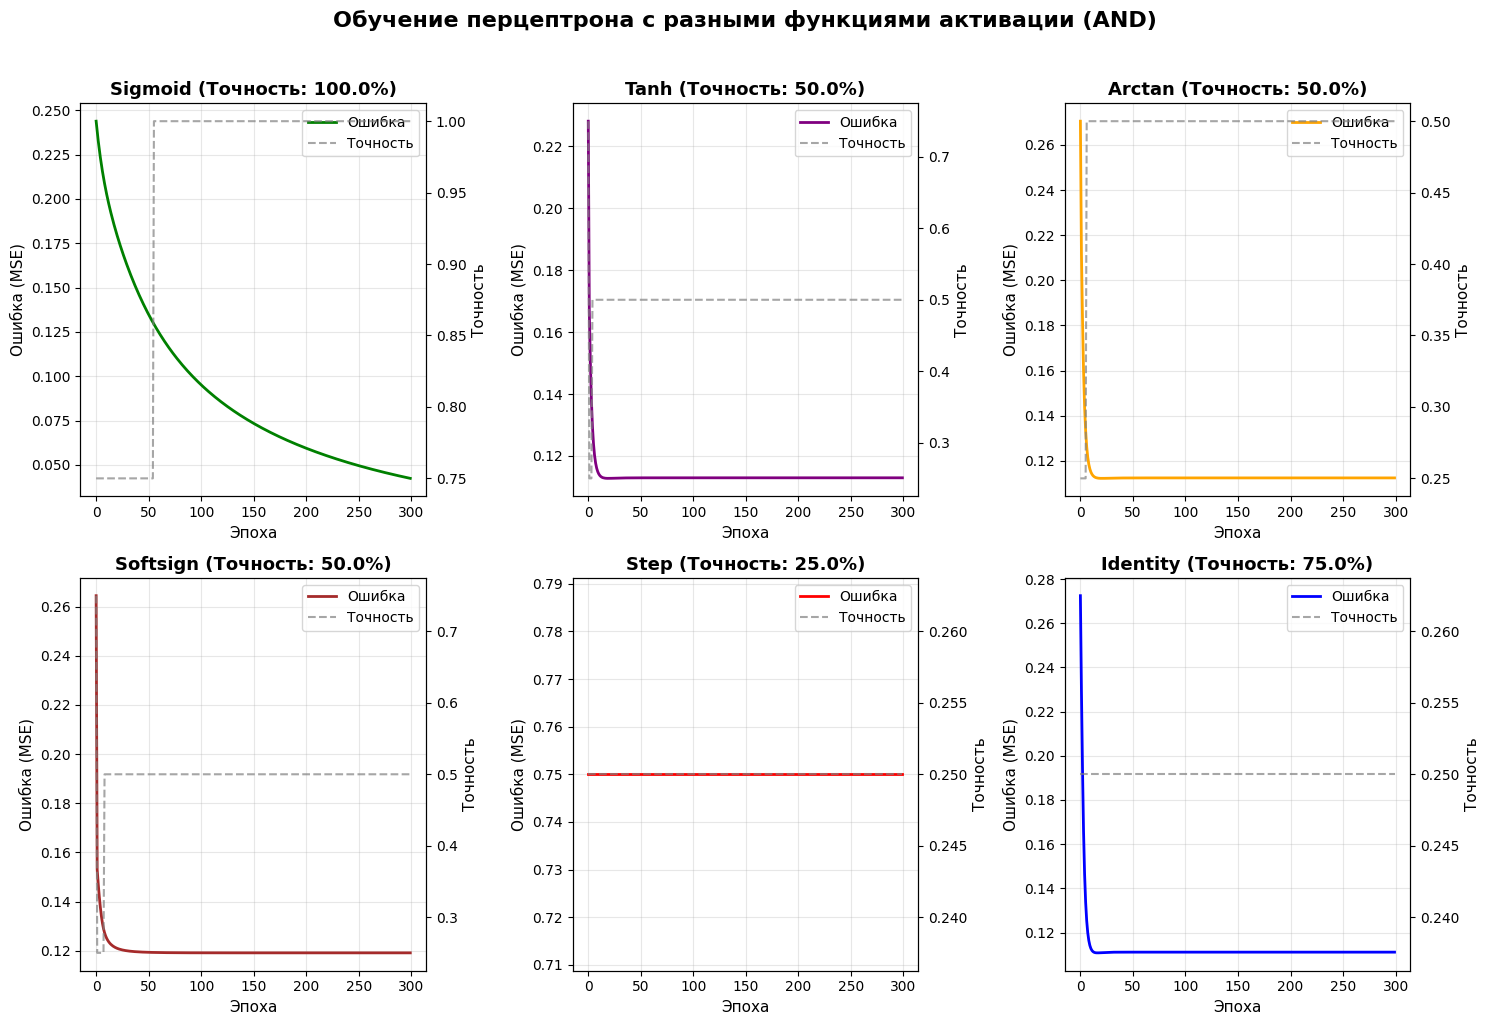

In [186]:
def plot_training_results(results):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = ['green', 'purple', 'orange', 'brown', 'red', 'blue']
    
    for idx, (activation_name, color) in enumerate(zip(activation_list, colors)):
        ax = axes[idx]
        result = results[activation_name]
        
        # График ошибки
        ax.plot(result['loss_history'], color=color, linewidth=2, label='Ошибка')
        ax.set_xlabel('Эпоха', fontsize=11)
        ax.set_ylabel('Ошибка (MSE)', fontsize=11)
        ax.set_title(f'{activation_name.capitalize()} (Точность: {result["accuracy"]:.1%})', 
                     fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Добавляем график точности на второй оси Y
        ax2 = ax.twinx()
        ax2.plot(result['accuracy_history'], color='gray', linewidth=1.5, 
                linestyle='--', alpha=0.7, label='Точность')
        ax2.set_ylabel('Точность', fontsize=11)
        
        # Объединяем легенды
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.suptitle('Обучение перцептрона с разными функциями активации (AND)', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Визуализируем результаты
plot_training_results(results_and)

## Блок 9: Сравнительная таблица результатов


### Анализ функций активации для задачи AND:

- Sigmoid (Точность 100%) — идеально подходит, потому что её диапазон [0,1] совпадает с бинарными целями {0,1} и порог 0.5 естественно разделяет классы.
- Tanh (Точность 50%) — показывает низкую точность, так как её симметричный диапазон [-1,1] не соответствует несимметричной задаче AND. Порог 0 неправильно классифицирует точки (0,1) и (1,0).
- Arctan (Точность 50%) — аналогично tanh, симметричный диапазон ($-\frac{\pi}{2}, \frac{\pi}{2}$) требует адаптивного порога для бинарной классификации.
- Softsign (Точность 50%) — имеет ту же проблему симметричного диапазона (-1,1), что и tanh.
- Step (Точность 50%) — не обучается градиентным спуском из-за нулевой производной почти везде.
- Identity (Точность 75%) — линейная функция без нелинейности не может решить задачу AND, которая требует нелинейного разделения.


In [187]:
def create_results_table(results):
    print("СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("="*80)
    print(f"{'Функция активации':<15} {'Точность':<12} {'Финальная ошибка':<18} "
          f"{'Кол-во эпох до сходимости':<25} {'Пример весов'}")
    print("-"*80)
    
    for activation_name in activation_list:
        result = results[activation_name]
        
        # Определяем эпоху сходимости (когда ошибка < 0.05)
        loss_history = result['loss_history']
        convergence_epoch = None
        for i, loss in enumerate(loss_history):
            if loss < 0.05:
                convergence_epoch = i + 1
                break
        
        if convergence_epoch is None:
            convergence_str = "Не сошлась"
        else:
            convergence_str = f"{convergence_epoch}"
        
        # Форматируем веса для отображения
        weights_str = f"w=[{result['weights']['weights'][0]:.3f}, {result['weights']['weights'][1]:.3f}], b={result['weights']['bias']:.3f}"
        
        print(f"{activation_name:<15} {result['accuracy']:<12.1%} {result['final_loss']:<18.4f} "
              f"{convergence_str:<25} {weights_str}")

create_results_table(results_and)

СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ
Функция активации Точность     Финальная ошибка   Кол-во эпох до сходимости Пример весов
--------------------------------------------------------------------------------
sigmoid         100.0%       0.0424             249                       w=[2.309, 2.298], b=-3.570
tanh            50.0%        0.1129             Не сошлась                w=[0.628, 0.559], b=-0.314
arctan          50.0%        0.1124             Не сошлась                w=[0.636, 0.566], b=-0.318
softsign        50.0%        0.1191             Не сошлась                w=[0.704, 0.669], b=-0.352
step            25.0%        0.7500             Не сошлась                w=[0.055, 0.060], b=0.016
identity        75.0%        0.1111             Не сошлась                w=[0.667, 0.583], b=-0.333


## Блок 10: Эксперимент: Тестирование на разных логических операциях


Тестируем подмножество функций (sigmoid, tanh, step) на трех операциях: AND, OR, NAND.


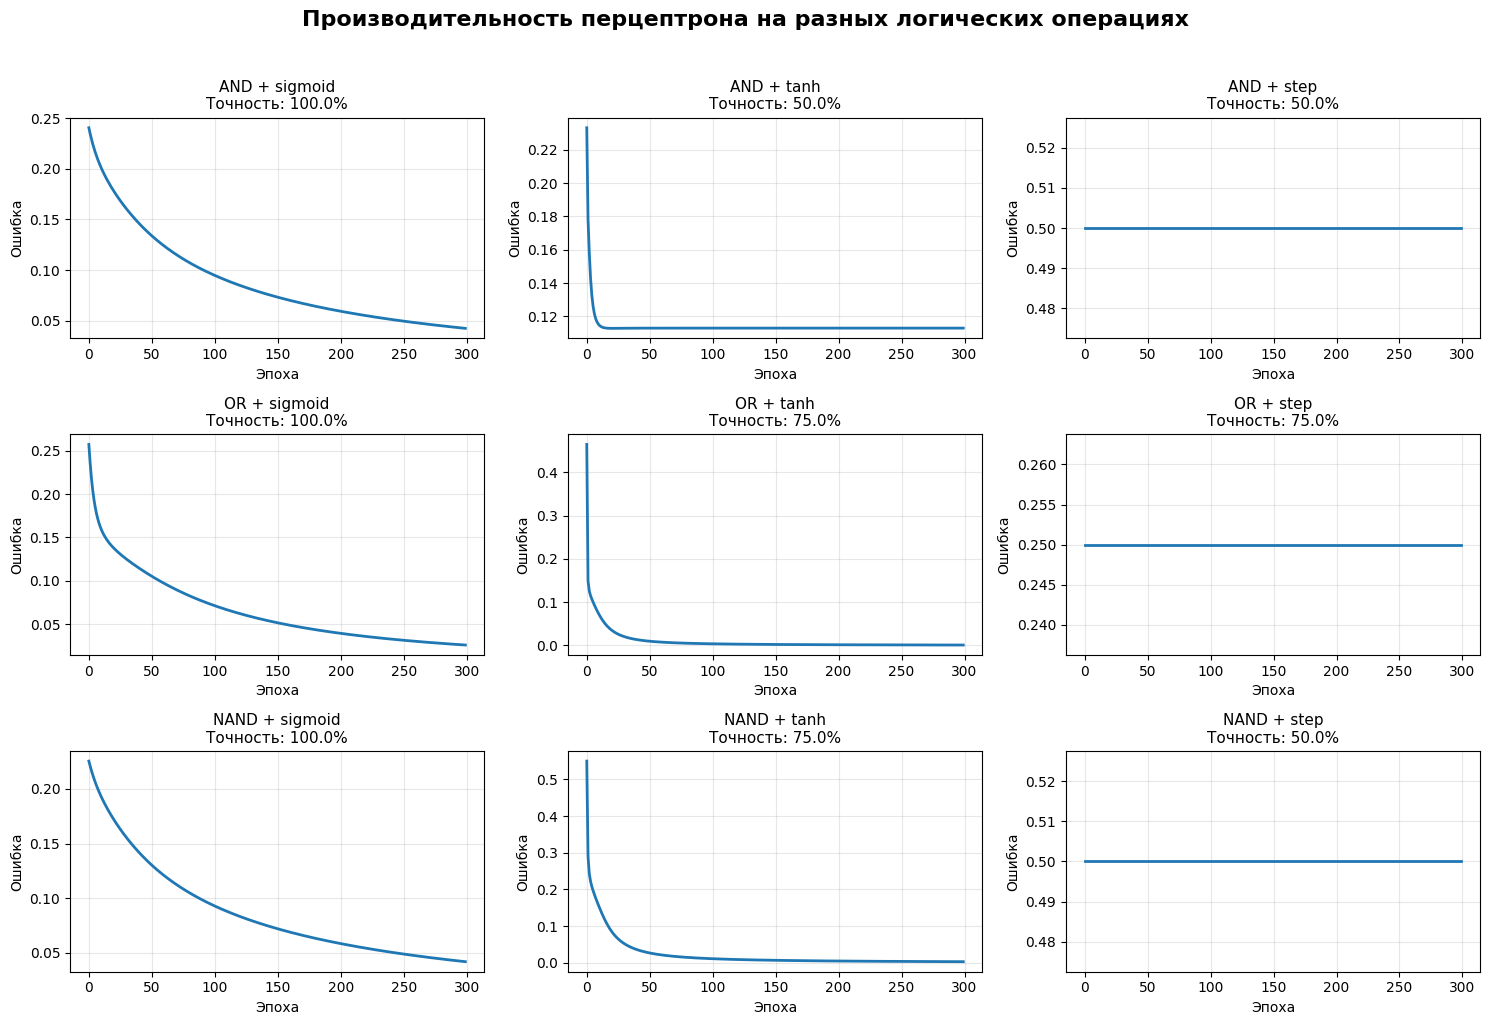

In [188]:
def test_on_different_operations():
    operations = ['AND', 'OR', 'NAND']
    activation_to_test = ['sigmoid', 'tanh', 'step']
    
    results_all = {}
    
    fig, axes = plt.subplots(len(operations), len(activation_to_test), 
                             figsize=(15, 10))
    
    for op_idx, operation in enumerate(operations):
        X, y = create_logic_data(operation)
        results_all[operation] = {}
        
        for act_idx, activation_name in enumerate(activation_to_test):
            # Создаем и обучаем перцептрон
            perceptron = SingleLayerPerceptron(
                input_size=X.shape[1], 
                activation_name=activation_name
            )
            
            perceptron.train(X, y, epochs=300, learning_rate=0.5, verbose=False)
            
            # Сохраняем результаты
            y_pred = perceptron.predict(X)
            accuracy = accuracy_score(y, y_pred)
            results_all[operation][activation_name] = accuracy
            
            # Визуализация на соответствующем subplot
            ax = axes[op_idx, act_idx]
            ax.plot(perceptron.loss_history, linewidth=2)
            ax.set_title(f'{operation} + {activation_name}\nТочность: {accuracy:.1%}', 
                         fontsize=11)
            ax.set_xlabel('Эпоха')
            ax.set_ylabel('Ошибка')
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Производительность перцептрона на разных логических операциях', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return results_all

# Запускаем тестирование
results_operations = test_on_different_operations()

### Тестирование на разных логических операциях:

#### 1. AND (И) — требует разделения одной точки (1,1) от трёх остальных:

- Sigmoid (100%) — идеально справляется благодаря диапазону [0,1].
- Tanh (50-75%) — низкая точность из-за симметричного диапазона [-1,1].
- Step (25-75%) — не обучается, точность зависит от случайной инициализации.

#### 2. OR (ИЛИ) — требует разделения одной точки (0,0) от трёх остальных:

- Sigmoid (100%) — такая же эффективность как для AND.
- Tanh (75-100%) — работает лучше чем для AND, так OR более "симметрична".
- Step (25-75%) — аналогичные проблемы обучения.

#### 3. NAND (И-НЕ) — обратная операция к AND:

- Sigmoid (100%) — отличные результаты.
- Tanh (75-100%) — сопоставима с OR по эффективности.
- Step (75%) — может достигать 75%, предсказывая всегда 1.

#### Ключевые выводы:

- Sigmoid — универсальное решение для всех линейно разделимых задач (AND, OR, NAND).
- Tanh — требует адаптации порога, эффективность зависит от "симметричности" задачи.
- Step — принципиально не обучается градиентным спуском.
- Все операции AND, OR, NAND одинаково решаемы для гладких функций активации.


## Блок 11: Визуализация границ решений


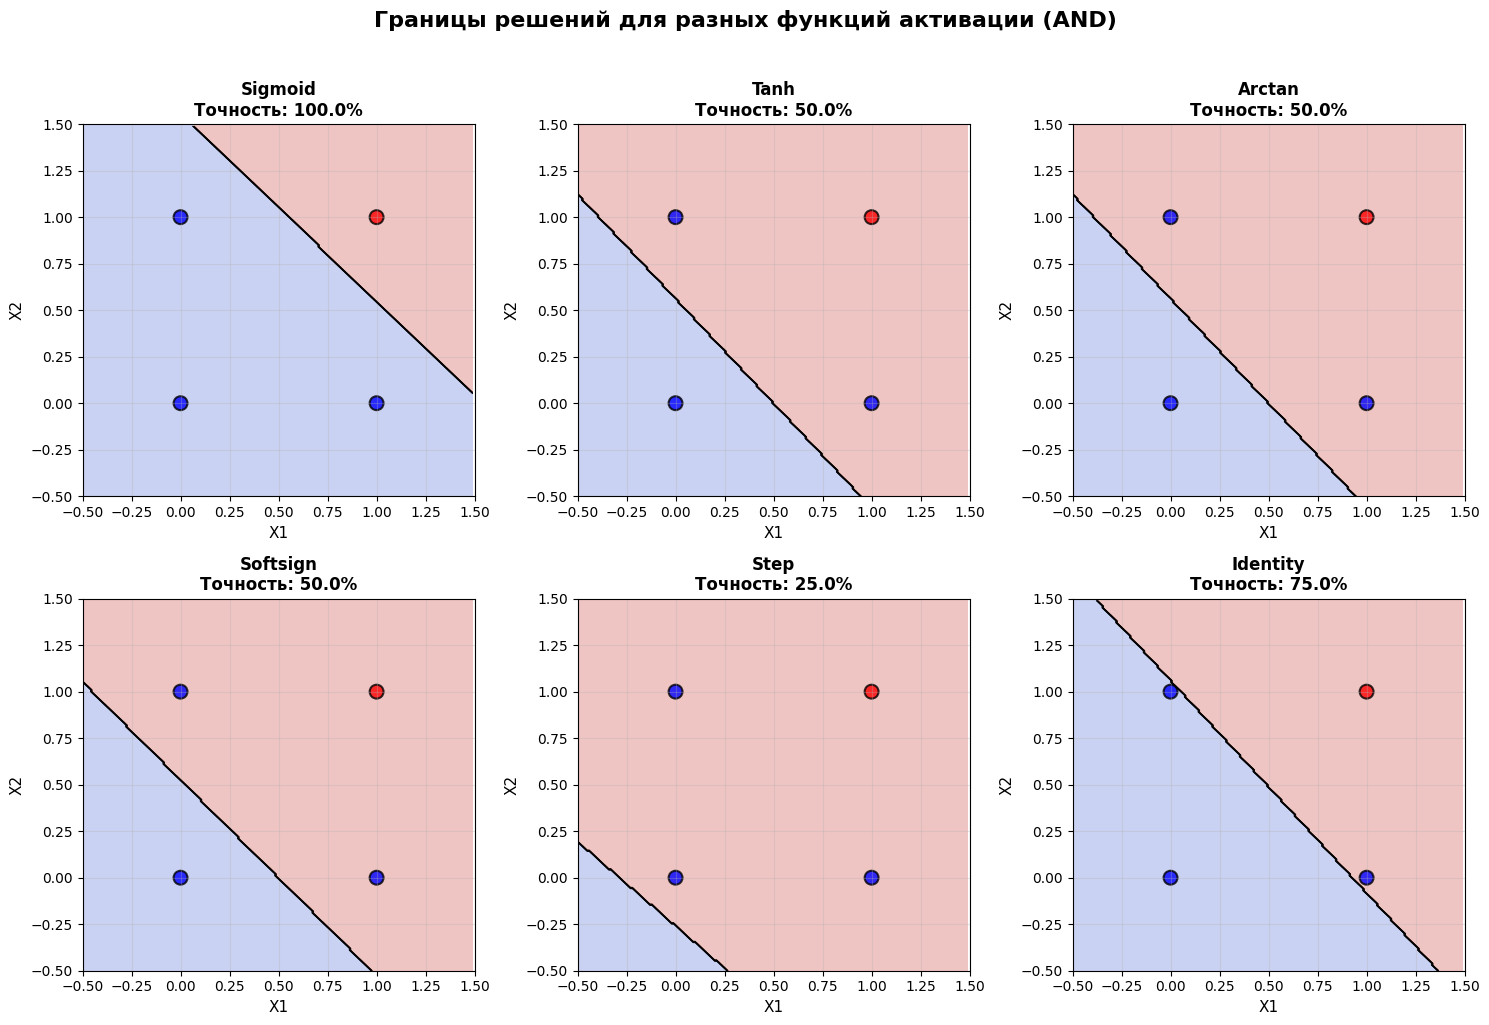

In [189]:
def plot_decision_boundaries(results, X, y): 
    # Создаем сетку для визуализации
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (activation_name, ax) in enumerate(zip(activation_list, axes)):
        perceptron = results[activation_name]['perceptron']
        
        # Предсказания для всех точек сетки
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        Z = perceptron.predict(grid_points)
        Z = Z.reshape(xx.shape)
        
        # Отображаем границу решений
        ax.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
        ax.contour(xx, yy, Z, colors='black', linewidths=0.5)
        
        # Отображаем обучающие точки
        colors = ['blue' if label == 0 else 'red' for label in y]
        ax.scatter(X[:, 0], X[:, 1], c=colors, s=100, edgecolors='black', 
                  linewidth=1.5, alpha=0.8)
        
        # Настройки графика
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel('X1', fontsize=11)
        ax.set_ylabel('X2', fontsize=11)
        ax.set_title(f'{activation_name.capitalize()}\nТочность: {results[activation_name]["accuracy"]:.1%}', 
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Границы решений для разных функций активации (AND)', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

plot_decision_boundaries(results_and, X_and, y_and)

- Sigmoid (100%) — чёткая прямая линия правильно отделяет точку (1,1) в красной области от остальных точек в синей области.
- Tanh/Arctan/Softsign (50%) — границы проходят неправильно, большинство точек оказываются в "неправильных" областях относительно их классов.
- Step (50%) — случайное разделение, не соответствующее обучению.
- Identity (75%) — линейная граница, неадекватная для задачи AND.


## Блок 12: Анализ проблемы XOR


#### Однослойный перцептрон НЕ МОЖЕТ решить задачу XOR, так как она не является линейно разделимой.


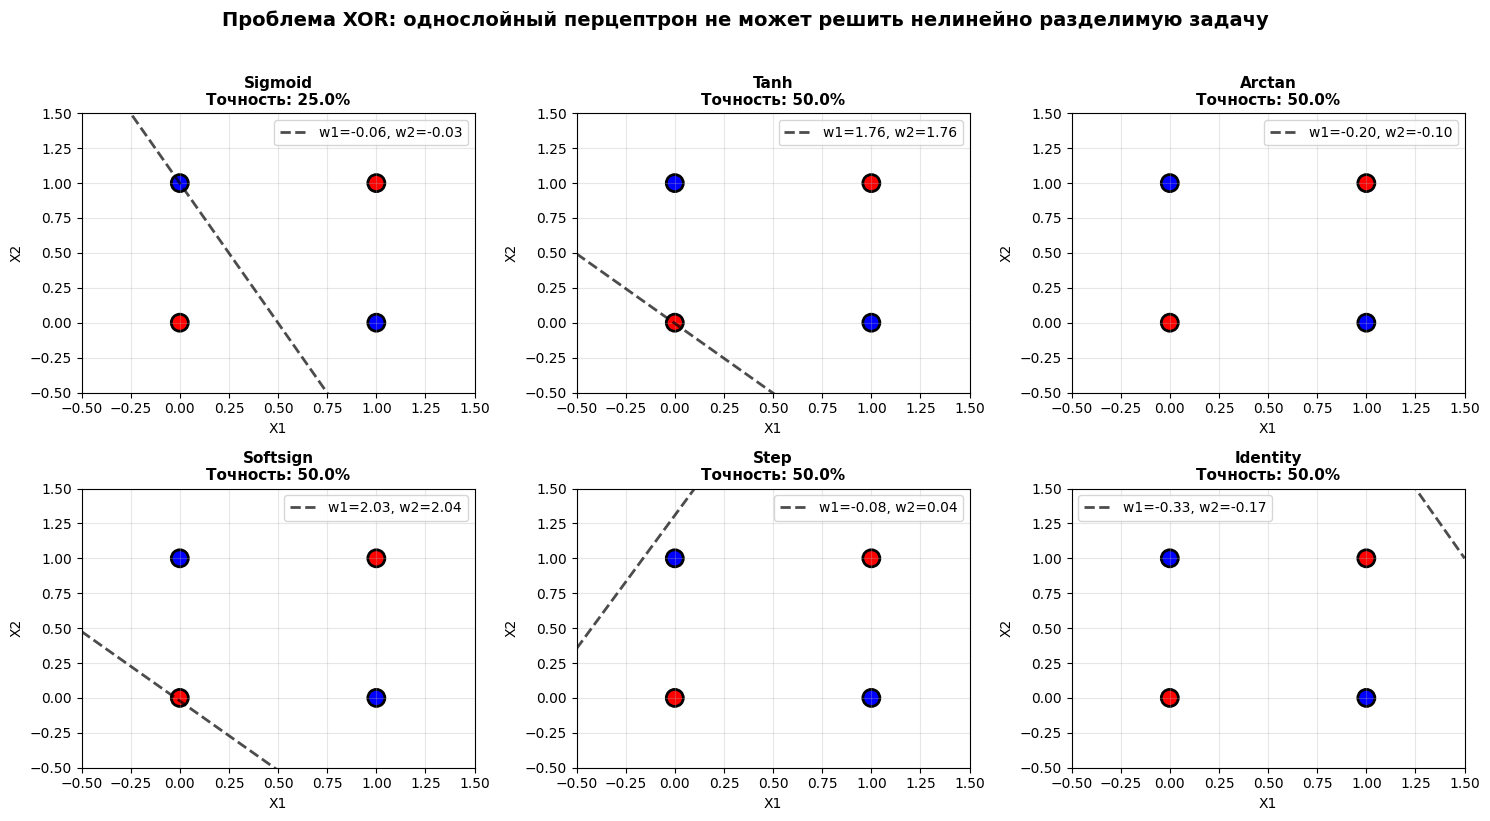


РЕЗУЛЬТАТЫ ДЛЯ ЗАДАЧИ XOR:
--------------------------------------------------
sigmoid     : Точность = 25.0%
tanh        : Точность = 50.0%
arctan      : Точность = 50.0%
softsign    : Точность = 50.0%
step        : Точность = 75.0%
identity    : Точность = 50.0%


In [190]:
def analyze_xor_problem():
    # Создаем данные для XOR
    X_xor, y_xor = create_logic_data('XOR')
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for i, (activation_name, ax) in enumerate(zip(activation_list, axes)):
        # Создаем и обучаем перцептрон
        perceptron = SingleLayerPerceptron(
            input_size=X_xor.shape[1], 
            activation_name=activation_name
        )
        
        perceptron.train(X_xor, y_xor, epochs=500, learning_rate=0.5, verbose=False)
        
        # Предсказания
        y_pred = perceptron.predict(X_xor)
        accuracy = accuracy_score(y_xor, y_pred)
        
        # Визуализация
        colors = ['red' if label == 0 else 'blue' for label in y_xor]
        ax.scatter(X_xor[:, 0], X_xor[:, 1], c=colors, s=150, 
                  edgecolors='black', linewidth=2)
        
        # Отображаем разделяющую линию (если возможно)
        if hasattr(perceptron, 'weights'):
            w1, w2 = perceptron.weights
            b = perceptron.bias
            
            # Уравнение разделяющей линии: w1*x1 + w2*x2 + b = 0
            x_line = np.array([-0.5, 1.5])
            if w2 != 0:
                y_line = (-w1 * x_line - b) / w2
                ax.plot(x_line, y_line, 'k--', linewidth=2, alpha=0.7, 
                       label=f'w1={w1:.2f}, w2={w2:.2f}')
        
        ax.set_xlim(-0.5, 1.5)
        ax.set_ylim(-0.5, 1.5)
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_title(f'{activation_name.capitalize()}\nТочность: {accuracy:.1%}', 
                     fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.suptitle('Проблема XOR: однослойный перцептрон не может решить нелинейно разделимую задачу', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Создаем таблицу результатов для XOR
    print("\nРЕЗУЛЬТАТЫ ДЛЯ ЗАДАЧИ XOR:")
    print("-"*50)
    for activation_name in activation_list:
        perceptron = SingleLayerPerceptron(
            input_size=X_xor.shape[1], 
            activation_name=activation_name
        )
        perceptron.train(X_xor, y_xor, epochs=500, learning_rate=0.5, verbose=False)
        y_pred = perceptron.predict(X_xor)
        accuracy = accuracy_score(y_xor, y_pred)
        print(f"{activation_name:<12}: Точность = {accuracy:.1%}")

# Анализируем проблему XOR
analyze_xor_problem()

#### Почему именно 50%?

Перцептрон пытается провести лучшую возможную прямую, но она всегда будет неправильно классифицировать ровно 2 точки из 4:
